## goal: build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not.

In [1]:
# ignore warnings
import  warnings
warnings.simplefilter('ignore')

# maintain a list in sorted order without having to sort the list after each insertion
import bisect
# import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
import xgboost as xgb



## Import data and join tables

In [2]:
# import data
data = pd.read_csv('/Users/cherry/Desktop/Machine learning/Fraud/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
# import another dataset: mapping each numeric ip address to its country
ad2c = pd.read_csv('/Users/cherry/Desktop/Machine learning/Fraud/IpAddress_to_Country.csv')
ad2c.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
# add country as a feature in fraud data, determine country based on IP address
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ad2c[(ad2c['lower_bound_ip_address'] <= ip_address) &
                          (ad2c['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Feature engineering

In [6]:
# feature engineering - possible frauds
# 1. small time difference between signup time and purchase time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [7]:
# 2. different user ids for the same device 
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [8]:
# 3. different user ids from the same IP address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [9]:
# 4. signup/ purchase day of a week and week of a year
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [26]:
# 5. transactions happened in countries with less users
country_count = data[['user_id','country']].groupby(['country']).count().reset_index()
data = data.merge(country_count,how = 'left',on = 'country')


In [27]:
data.head()

,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week,user_id_y
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16,7306
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24,58049
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1,58049
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19,21966
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37,58049


In [29]:
data.rename(columns={'user_id_y': 'country_count'}, inplace=True)

In [30]:
data.head()

,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week,country_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16,7306
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24,58049
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1,58049
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19,21966
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37,58049


In [31]:
# delete unnecessary features such as user id and device_id and keep other features

features = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'time_diff', 'device_num', 'ip_num', 'class','country_count']
data = data[features]
data.head()



,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,time_diff,device_num,ip_num,class,country_count
0,1,9,5,16,34,SEO,Chrome,M,39,13882,1,1,0,7306
1,6,23,0,24,16,Ads,Chrome,F,53,17944,1,1,0,58049
2,3,1,3,1,15,SEO,Opera,M,53,1,12,12,1,58049
3,1,18,0,19,44,SEO,Safari,M,41,60085,1,1,0,21966
4,1,30,2,37,39,Ads,Safari,M,45,41461,1,1,0,58049


In [33]:
# one-hot code
data['is_male'] = (data.sex == 'M').astype(int)
del data['sex']

In [38]:
data = pd.get_dummies(data,columns=['source','browser'])

del data['source']
del data['browser']
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,age,time_diff,device_num,ip_num,class,country_count,is_male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,1,9,5,16,34,39,13882,1,1,0,7306,1,0,0,1,1,0,0,0,0
1,6,23,0,24,16,53,17944,1,1,0,58049,0,1,0,0,1,0,0,0,0
2,3,1,3,1,15,53,1,12,12,1,58049,1,0,0,1,0,0,0,1,0
3,1,18,0,19,44,41,60085,1,1,0,21966,1,0,0,1,0,0,0,0,1
4,1,30,2,37,39,45,41461,1,1,0,58049,1,1,0,0,0,0,0,0,1


## Train the model

In [44]:
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,age,time_diff,device_num,ip_num,class,country_count,is_male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,1,9,5,16,34,39,13882,1,1,0,7306,1,0,0,1,1,0,0,0,0
1,6,23,0,24,16,53,17944,1,1,0,58049,0,1,0,0,1,0,0,0,0
2,3,1,3,1,15,53,1,12,12,1,58049,1,0,0,1,0,0,0,1,0
3,1,18,0,19,44,41,60085,1,1,0,21966,1,0,0,1,0,0,0,0,1
4,1,30,2,37,39,45,41461,1,1,0,58049,1,1,0,0,0,0,0,0,1


In [46]:
seed = 999
X = data.loc[:,data.columns != 'class']
y = data['class']

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)



In [47]:
# find best number of trees
params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)
cv_results

[0]	train-auc:0.84397+0.000926769	test-auc:0.843742+0.00366975
[1]	train-auc:0.844001+0.00106853	test-auc:0.843524+0.00362196
[2]	train-auc:0.844159+0.000974472	test-auc:0.843425+0.0035507
[3]	train-auc:0.844261+0.000983106	test-auc:0.843422+0.00359528
[4]	train-auc:0.844561+0.000970212	test-auc:0.843568+0.00361833
[5]	train-auc:0.84517+0.0014675	test-auc:0.844376+0.00315942
[6]	train-auc:0.845497+0.00169336	test-auc:0.844452+0.0030225
[7]	train-auc:0.846375+0.00216841	test-auc:0.844555+0.00259896
[8]	train-auc:0.848396+0.0011254	test-auc:0.845772+0.00355173
[9]	train-auc:0.849989+0.0020261	test-auc:0.846559+0.0042672
[10]	train-auc:0.85201+0.00158468	test-auc:0.847083+0.00438298
[11]	train-auc:0.853955+0.00194348	test-auc:0.847071+0.00430247
[12]	train-auc:0.85618+0.00168446	test-auc:0.846644+0.00449796
[13]	train-auc:0.857319+0.00196706	test-auc:0.846024+0.00393107
[14]	train-auc:0.858287+0.00201717	test-auc:0.844188+0.00300163
[15]	train-auc:0.859833+0.0025004	test-auc:0.845016+0.00

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.843970,0.000927,0.843742,0.003670
1,0.844001,0.001069,0.843524,0.003622
2,0.844159,0.000974,0.843425,0.003551
3,0.844261,0.000983,0.843422,0.003595
4,0.844561,0.000970,0.843568,0.003618
5,0.845170,0.001467,0.844376,0.003159
6,0.845497,0.001693,0.844452,0.003022
7,0.846375,0.002168,0.844555,0.002599
8,0.848396,0.001125,0.845772,0.003552
9,0.849989,0.002026,0.846559,0.004267


In [48]:
n_best_trees = cv_results.shape[0]
n_best_trees

11

## plot ROC and choose threshold

In [49]:
# Training and test sets are biased, we cannot plot ROC on them
# split the training dataset into training set and validation set
# retrain on training set and plot ROC on validation set and choose a proper cutoff value

def plot_validation_roc():
 
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),(valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

roc = plot_validation_roc()

[0]	train_only-auc:0.84384	validate-auc:0.844361
[1]	train_only-auc:0.843909	validate-auc:0.84442
[2]	train_only-auc:0.843995	validate-auc:0.844378
[3]	train_only-auc:0.844056	validate-auc:0.844346
[4]	train_only-auc:0.844071	validate-auc:0.844357
[5]	train_only-auc:0.846591	validate-auc:0.844256
[6]	train_only-auc:0.846602	validate-auc:0.844341
[7]	train_only-auc:0.846635	validate-auc:0.844333
[8]	train_only-auc:0.847656	validate-auc:0.844251
[9]	train_only-auc:0.848427	validate-auc:0.843791
[10]	train_only-auc:0.849	validate-auc:0.843447


Text(0, 0.5, 'TPR')

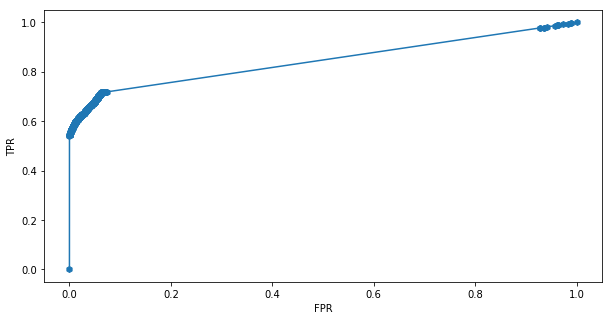

In [50]:
plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

In [ ]:
# Trade-off
# when FP is more important, we should minimize FPR, increase the threshold. (TPR is also decreased.)
# when FN is more important, we should min FNR, decrease the threshold. (FPR is also increased)
# in this case, even if we find some fraudulent activities that are actually not, there are next steps, so min FN.
# choose a smaller threshold


In [ ]:
# how to use the model:
# If predicted fraud probability < X, no fraudulent activities. (majority)
# If X <= predicted fraud probability < Z, the user in the risk of frauds;
# solution: use additional verification step, including verifying phone number via a code sent by SMS or email.
# If predicted fraud probability >= Z, there is a high risk of a fraud.
# solution: warn the user; freeze the account; check the activity manually.